In [6]:
import numpy as np
import matplotlib.pyplot as plt
from utils.pca_method import generate_tau_sample, rearing_detection
from utils.baseline_method import continuous_detection
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter
from glob import glob
import os
from matplotlib import gridspec
from utils.class_utils import calculate_speed
from utils.basic_utils import joint_density_function
import seaborn as sns
import torch 



In [18]:
import torch
# import torch.nn as nn 
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm
from torch import nn

In [7]:
root_path = './data/processed_data/'
rat_id = 'FS11'

In [145]:
all_data= np.load('%s/network.npy'%(root_path+rat_id),allow_pickle=True).item()
all_x = all_data['x']
all_y = all_data['y']
longer_array = all_data['longer_array']
label_array = all_data['label_array']
event_num = longer_array.shape[0]

In [146]:
all_x = generate_tau_sample(longer_array, tau = 10, step = 5, T = 600, k = 4)

836

In [696]:
def generate_ylabel(label_array,tau = 10,step = 5, T = 600):
    reshaped_label = label_array.reshape((label_array.shape[0],1, label_array.shape[-1]))
    temp = generate_tau_sample(reshaped_label,tau=tau,step = step,T =T, k =1 )
    sumed_label = temp[:,0:step].sum(axis=1)
    y_label = np.zeros_like(sumed_label)
    print(temp.shape)
    y_label[sumed_label>=step/2] = 1
    return y_label

In [1779]:
bad_label_idx = np.arange(284,300) 
bad_label_idx = np.append(bad_label_idx, np.arange(361, 370),)
bad_label_idx = np.append(bad_label_idx, np.array([458,459]))


In [1793]:
train_event_idx = np.arange(0,460)


In [1794]:
clean_event_idx = np.delete(train_event_idx, bad_label_idx)

In [780]:
tau = 30
step = 5
T = 600
k = 4

In [372]:
def normalize(x):
    return (x - x.mean(axis = 0))/x.std(axis = 0)

In [781]:
x_tr = normalize(generate_tau_sample(longer_array[0:int(event_num*0.6),:,:], tau= tau, step=step, T = T,k = k))
y_tr = generate_ylabel(label_array[0:int(event_num*0.6),:],tau=tau, step=step,T = T)
x_te = normalize(generate_tau_sample(longer_array[int(event_num*0.6):int(event_num*0.8),:,:], tau= tau, step=step, T = T,k = k))
y_te = generate_ylabel(label_array[int(event_num*0.6):int(event_num*0.8),:],tau=tau, step=step,T = T)
x_vl = normalize(generate_tau_sample(longer_array[int(event_num*0.8):,:,], tau= tau, step=step, T = T,k = k))
y_vl = generate_ylabel(label_array[int(event_num*0.8):,:],tau=tau, step=step,T = T)

(57615, 30)
(19205, 30)
(19320, 30)


In [782]:
xtr = torch.tensor(x_tr, dtype=torch.float)
xte = torch.tensor(x_te, dtype=torch.float)
xvl = torch.tensor(x_vl, dtype=torch.float)
ytr = torch.tensor(y_tr, dtype=torch.float)
yte = torch.tensor(y_te, dtype=torch.float)
yvl = torch.tensor(y_vl, dtype=torch.float)

ytr = ytr[:,None]
yte = yte[:,None]
yvl = yvl[:,None]

In [1833]:
two_class_relabley = np.copy(relabeld_y)
two_class_relabley[two_class_relabley ==2] = 1

In [1834]:
clean_tr = normalize(generate_tau_sample(longer_array[clean_event_idx,:,:],tau = tau,step = step, T = T,k =k))
clean_label = generate_ylabel(two_class_relabley[clean_event_idx,:],tau=tau, step=step,T = T)
cleanlable = torch.tensor(clean_label, dtype=torch.float)
cleantr = torch.tensor(clean_tr, dtype= torch.float)
cleanlabel = cleanlable[:,None]

(49795, 30)


## model

In [1824]:
input_size = x_tr.shape[-1]
hidden_size = 1
# initialize parameters for learning 
hidden_size = 1 
num_epochs = 2000
learning_rate = 0.002
print(input_size)
sec_hidden_size = 4

120


In [763]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_size),
                      nn.Sigmoid(),
                      nn.Linear(hidden_size, sec_hidden_size),
                      nn.ReLU(),
                      nn.Linear(hidden_size, 1),
                      nn.Sigmoid())
print(model)

Sequential(
  (0): Linear(in_features=80, out_features=1, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=1, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1, out_features=1, bias=True)
  (5): Sigmoid()
)


In [177]:
# takes in a module and applies the specified weight initialization
def weights_init_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(-0.01, 0.01)
        m.bias.data.fill_(0)
            

In [1835]:
hidden = [8]

min_e_tr = np.empty(len(hidden))
min_e_te = np.empty(len(hidden))
min_e_vl = np.empty(len(hidden))
last_e_te = np.empty(len(hidden))
last_e_vl = np.empty(len(hidden))

 
# Using for loop
for i in range(len(hidden)):
    hidden_size = hidden[i]
    print(hidden_size)

    # Let's train our model with 100 epochs
    e_tr = np.empty(num_epochs)
    e_te = np.empty(num_epochs)
    e_vl = np.empty(num_epochs)

    # Build a feed-forward network
    model = nn.Sequential(nn.Linear(input_size, hidden_size),
                        nn.Sigmoid(),
                        nn.Linear(hidden_size, sec_hidden_size),
                        nn.Sigmoid(),
                        nn.Linear(sec_hidden_size, 1),
                        nn.Sigmoid())
    model.apply(weights_init_uniform)

    criterion = nn.BCELoss() # negative log likelihood loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

    for epoch in tqdm(range(num_epochs)):
        # Get our predictions
        otr = model(cleantr)
        
        loss = criterion(otr, cleanlabel)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
  
        e_tr[epoch] = loss
        e_te[epoch] = criterion(model(xte), yte)
        e_vl[epoch] = criterion(model(xvl), yvl)

        
        
    min_e_tr[i] = np.min(e_tr)
    min_e_te[i] = np.min(e_te)
    min_e_vl[i] = np.min(e_vl)
    last_e_te[i] = e_te[-1]
    last_e_vl[i] = e_vl[-1]
        


 

8


  0%|          | 0/2000 [00:00<?, ?it/s]

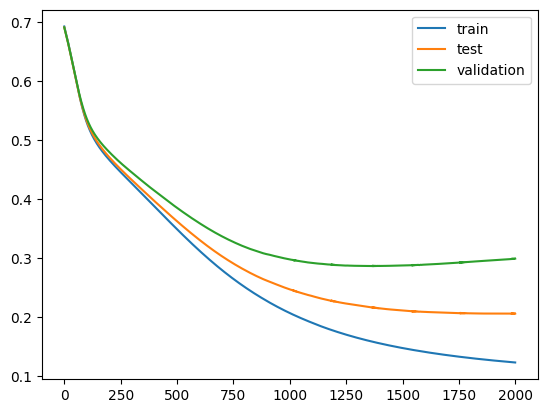

In [1836]:
labels = ['train','test','validation']
es = [e_tr, e_te,e_vl]
for i,label in enumerate(labels):
    plt.plot(es[i], label = label)
plt.legend()



In [777]:
def reorganize_xmatrix(x,tau = 10, step = 5, T = 600,k = 4):
    num_slice = (T-tau)//step +1  # if step = tau, no overlap
    num_event = int(x.shape[0]/num_slice)
    feature_array = np.zeros((num_event,k,T))

    for i, end_idx in enumerate(np.arange(tau, T+1, step)):
        for j in range(k):
            feature_array[:,j,end_idx-tau:end_idx] = x[i*num_event:(i+1)*num_event,j*tau:(j+1)*tau]
   
    return feature_array

def generate_label_array(y,tau = 10, step=5, T=600):
    num_slice = (T-tau)//step +1  # if step = tau, no overlap
    num_event = int(y.shape[0]/num_slice)
    label_array = np.zeros((num_event,T))

    # for the first 
    for i, end_idx in enumerate(np.arange(tau, T+1, step)):
        temp = np.tile(y[i*num_event:(i+1)*num_event],reps=(tau,1)).T
        label_array[:,end_idx-tau:end_idx] = temp # the latter lable will overlap the previous one
    return label_array
    

In [773]:
y_label.shape

(59619, 1)

In [1849]:
def process_model_res(model, xtr, x_tr, tau = 10, step = 5, T = 600, k = 4):
    
    x_array= reorganize_xmatrix(x_tr, tau = tau, step = step, T = T, k = k)
    
    # generate label from model
    y_pro =model(xtr).detach().numpy()
    y_label = np.zeros_like(y_pro)
    y_label[y_pro>=0.5] = 1
    
    reshaped_label = generate_label_array(y_label.reshape(-1), tau = tau, step = step, T = T, )
    reshaped_pro = generate_label_array(y_pro.reshape(-1), tau = tau, step = step, T = T,)
    return x_array, reshaped_label, reshaped_pro

In [1843]:
origin_x_tr = generate_tau_sample(longer_array[0:int(event_num*0.6),:,:], tau= tau, step=step, T = T,k = k)
origin_x_te = generate_tau_sample(longer_array[int(event_num*0.6):int(event_num*0.8),:,:], tau= tau, step=step, T = T,k = k)

In [1853]:
x_array, y_array,y_pro = process_model_res(model, xtr, origin_x_tr,tau = tau, step = step, T = T, k = k)

In [1550]:
feature_labels = ['height','pitch', 'speed_1d','speed_2d','rearing prob']
vmaxs = [0.75, 60,0.5, 1.3,1]
vmins = [0.45, -60,-0.5,0,0]
k=4
sigma = 5
T =600


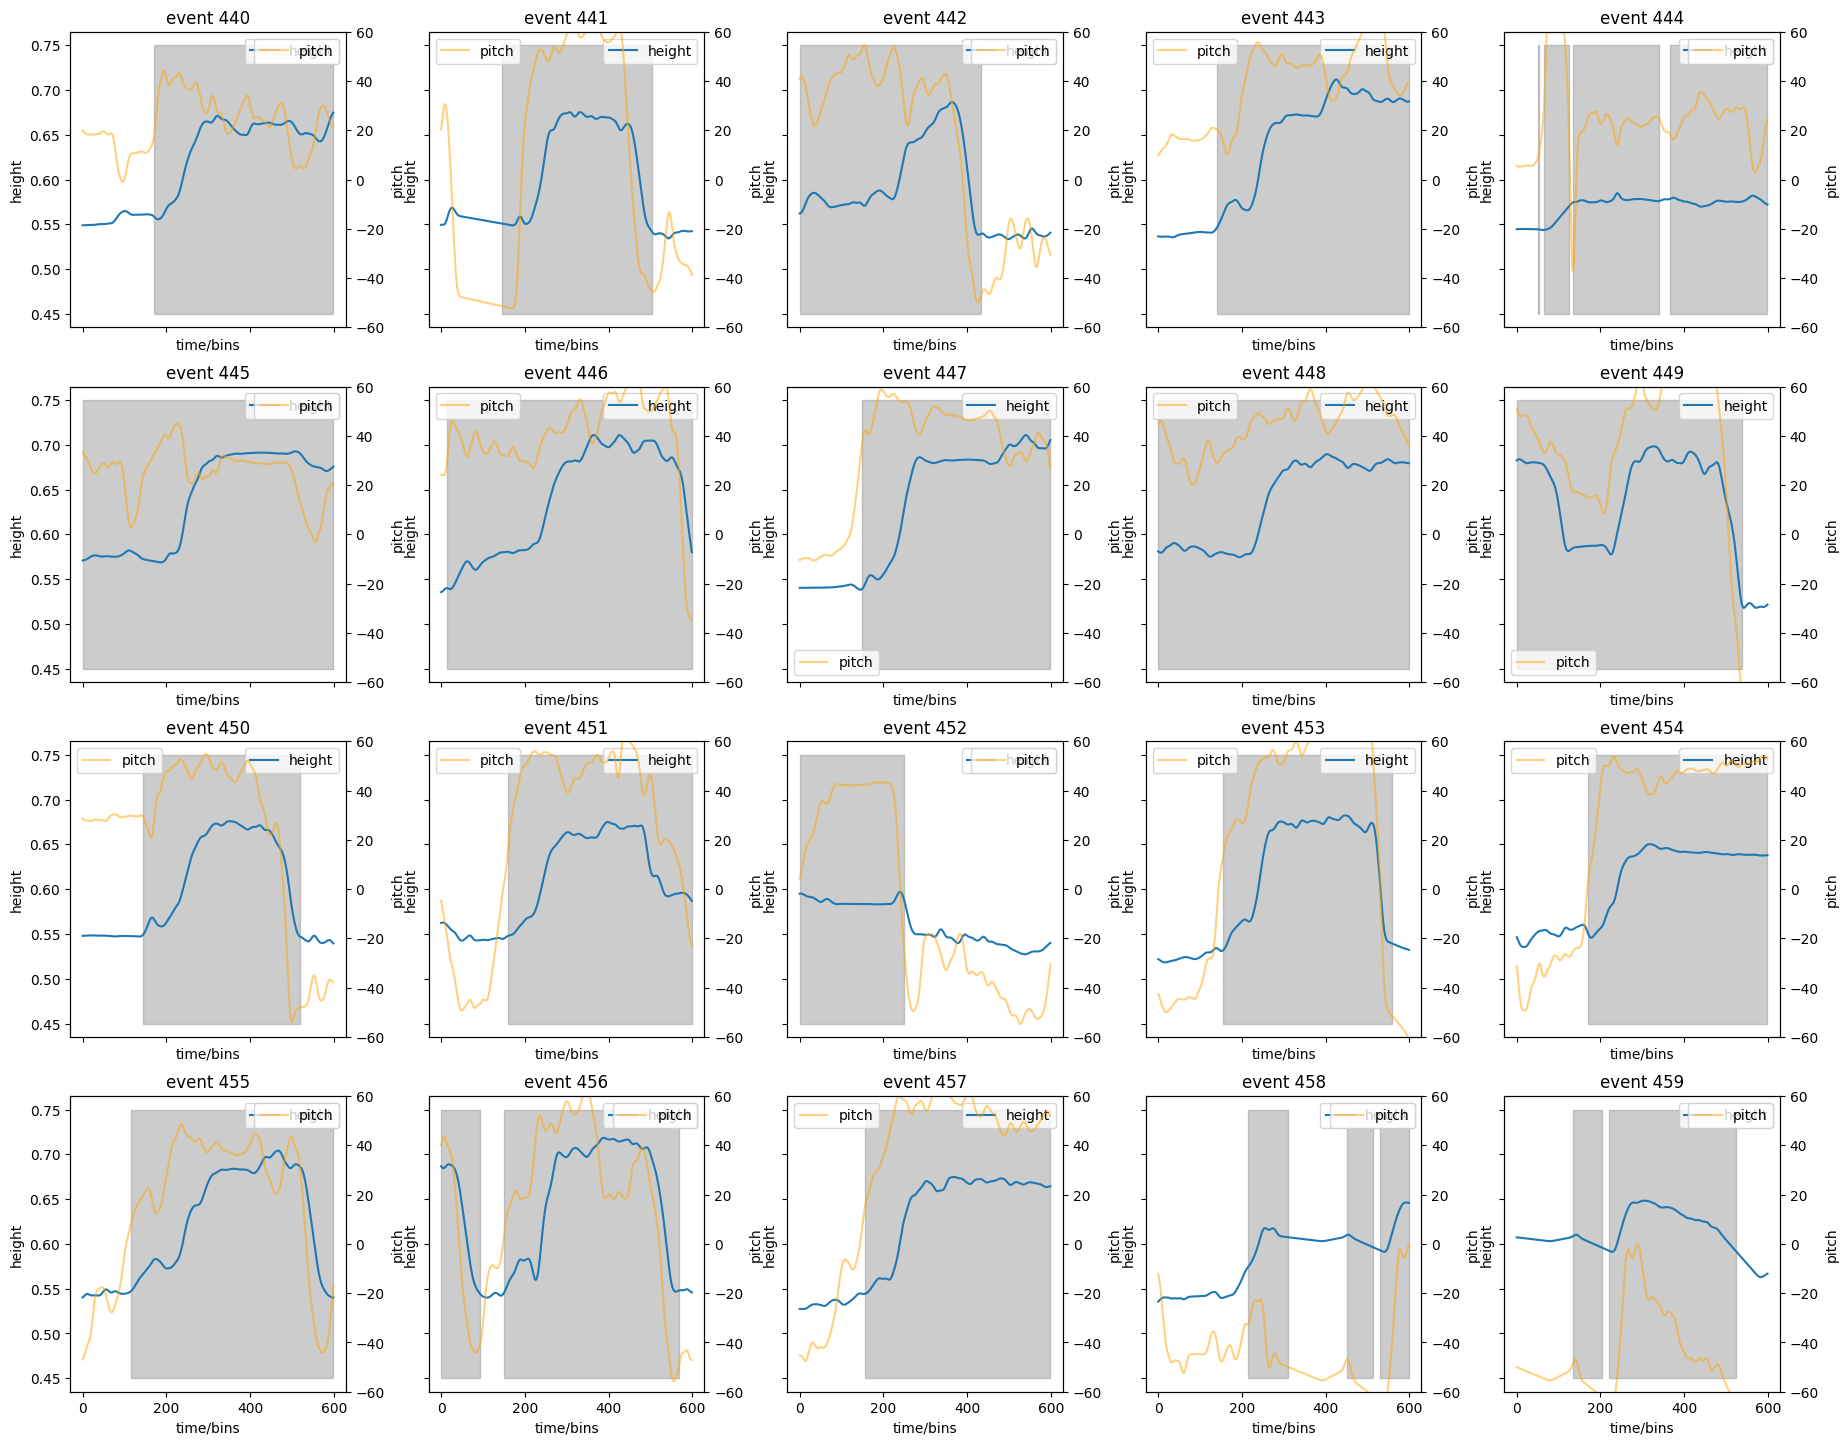

In [1856]:
which_feature = 0
fig, axis = plt.subplots(4,5, figsize = (19,16), sharey = True, sharex = True)
axis = axis.flatten()

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.90,
                    hspace=0.2, wspace=0.3)
begin_idx = 440

second_feature = 1

for i,event_id in enumerate(range(begin_idx,begin_idx+20)):
    axis[i].plot(x_array[event_id,which_feature,:],label = 'height')
    # stop_idx = T + len_rearing[sorted_idx][event_id] + after_min_distance_place[sorted_idx][event_id]*step
    # # axis[i].vlines(rearing_idx,ymin = vmaxs[which_feature], ymax =vmins[which_feature], label ='begin rearing', linestyles = 'dashed', color = 'red', alpha = 0.6)
    # axis[i].fill_between([rearing_idx, rearing_idx+tau], vmins[0],vmaxs[0],color = 'grey',alpha = 0.4, label = 'rearing initiation')
    # if stop_idx <T+after_stand_up + tau:
    _,seperated_rearing_time = continuous_detection(np.where(y_array[event_id]==1)[0],1,total_tolerance=100,seperate=True)
    if len(seperated_rearing_time[0])>0:
        for this_time in seperated_rearing_time:
            axis[i].fill_between([this_time[0], this_time[-1]],vmins[0],vmaxs[0],color = 'grey',alpha = 0.4,)
    
    _,seperated_preparation_time = continuous_detection(np.where(y_array[event_id]==2)[0],1,total_tolerance=100,seperate=True)
    if len(seperated_preparation_time[0])>0:
        for this_time in seperated_preparation_time:
            axis[i].fill_between([this_time[0], this_time[-1]],vmins[0],vmaxs[0],color = 'red',alpha = 0.4,)

        # axis[i].axvspan(z,z+1,color = 'grey',alpha = 0.1)

    axis[i].set_xlabel('time/bins')
    axis[i].set_ylabel('%s'%feature_labels[which_feature])
    axis[i].legend()
    axis[i].set_title('event %d'%(event_id, ))
    
    axis2 = axis[i].twinx()
    axis2.set_ylim([vmins[second_feature], vmaxs[second_feature]])
    axis2.plot(x_array[event_id,second_feature,:],label = feature_labels[second_feature],color = 'orange',alpha = 0.5)
    axis2.set_ylabel(feature_labels[second_feature])
    axis2.legend()
    
# title = 'k= %d, %s,%s,Smooth sigma = %d, rearing detection when T = %d, tau = %d, turn point (%.2f,%.2f),begin index %d'%(k,feature_labels[0],feature_labels[second_feature], sigma, T, tau, selected_place[0,which_place], selected_place[1,which_place],begin_idx)
# fig.suptitle(title, fontsize = 16)
# if save_fig == True:
#     fig.savefig('%s/%s.png'%(save_path, title), format ='png',)

In [1784]:
which_idx = 440


np.where(relabeld_y[which_idx]==1)

(array([200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
        213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
        226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
        239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251,
        252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,
        265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277,
        278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290,
        291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303,
        304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316,
        317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329,
        330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342,
        343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355,
        356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368,
        369, 370, 371, 372, 373, 374, 375, 376, 377

In [1788]:
relabeld_y[which_idx,180:200] =1

In [1662]:
# relabeld_y[400:420,:] = y_array[400:420,:]

In [1188]:
# relabeld_y_wider  = np.copy(relabeld_y)

In [1798]:
# np.save('%s/relabeld_y_three_class.npy'%root_path+rat_id, relabeld_y)

In [1860]:
# np.save('%s/train_data.npy'%root_path+rat_id, {'xtrain':longer_array[clean_event_idx],'ytrain':relabeld_y[clean_event_idx]})

In [1]:
a, b = np.load('%s/train_data.npy'%root_path+rat_id)

NameError: name 'np' is not defined